## Stock Price Prediction Using Regression and Neural Network
### Purpose: Explain why ridge regression and the LTSM neural network were chosen as the two models to compare.
### Objective: Compare the performance of both models to see which is the better option when used on testing data.
### Note: Stock prices are very volatile and can be affected by a multitude of external factors, these models are just examples of how one could try and predict future stock prices in a completely normal environment.

In [191]:
#Importing necessary libraries for reading in stock price data, visualization tools, and building ML models
import yfinance as yf
from pandas_datareader import data as pdr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#We will be using sci-kit learn and Keras for the ML models, these two libraries have become the standard framework in Python
#for machine learning.
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

In [192]:
#Using yfinance to read in 5 years of daily closing prices and volume for Etsy to see if we can predict it's future price.
#Previous prices and volume will be the two predictors
stockDF = pdr.get_data_yahoo('ETSY', start = '2011-03-01', end = '2021-03-01')[['Adj Close', 'Volume']]
stockDF.reset_index(inplace = True)

#It should already be in ascending order by date but using sort_values to confirm.
stockDF = stockDF.sort_values(by = ['Date'])
stockDF

,Date,Adj Close,Volume
0,2015-04-16,30.000000,19763300
1,2015-04-17,27.580000,3965500
2,2015-04-20,24.900000,3076200
3,2015-04-21,25.750000,2184700
4,2015-04-22,25.120001,1442500
...,...,...,...
1474,2021-02-23,210.750000,3646100
1475,2021-02-24,209.100006,2179000
1476,2021-02-25,197.580002,3698700
1477,2021-02-26,220.270004,11043400


In [193]:
#Examining the datatypes of the dataframe to confirm everything imported correctly
stockDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1479 entries, 0 to 1478
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1479 non-null   datetime64[ns]
 1   Adj Close  1479 non-null   float64       
 2   Volume     1479 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 46.2 KB


### Step 1: Data Preprocessing
#### - Splitting the data into 75% training and 25% testing sets
#### - The test set contains data that the training model has never seen.
#### - Using a scaler on the data to normalize it due to the widely different volume number and price
#### - Creating a target column in the dataset that represents the closing price for the next day since that's what we're predicting
#### - Specifying the closing price and volume as the features and the price for the next day as the target

In [194]:
#Adding the target column to the dataframe
stockDF['Target'] = stockDF['Adj Close'].shift(-1) #Setting the target variable to the price of the next day


#Removing the last row since it will be null
stockDF = stockDF[:-1]

#Showing the new dataframe
stockDF

,Date,Adj Close,Volume,Target
0,2015-04-16,30.000000,19763300,27.580000
1,2015-04-17,27.580000,3965500,24.900000
2,2015-04-20,24.900000,3076200,25.750000
3,2015-04-21,25.750000,2184700,25.120001
4,2015-04-22,25.120001,1442500,25.620001
...,...,...,...,...
1473,2021-02-22,213.119995,2652200,210.750000
1474,2021-02-23,210.750000,3646100,209.100006
1475,2021-02-24,209.100006,2179000,197.580002
1476,2021-02-25,197.580002,3698700,220.270004


In [195]:
#Using the MinMaxScaler from sklearn to restrict the values to be from 0 to 1
scaler = MinMaxScaler(feature_range = (0, 1))
scaledStockDF = scaler.fit_transform(stockDF.drop(columns = 'Date')) #Not including the data field when scaling

#Examining the scaled dataframe
scaledStockDF

array([[0.10391209, 0.73815549, 0.08907732],
       [0.09327472, 0.14238304, 0.07782722],
       [0.0814945 , 0.10884544, 0.08139535],
       ...,
       [0.89116486, 0.0750099 , 0.80270338],
       [0.84052748, 0.13232138, 0.89795148],
       [0.94026375, 0.40930741, 1.        ]])

In [196]:
#Setting the features (predictors) to be the closing price and volume and setting the target to be the price for the next day
features = scaledStockDF[:, :2] #All rows and all columns up to the target
target = scaledStockDF[:, 2:] #All rows and just the target column

#Printing out the shape on both to confirm that we're getting the right data
print(features.shape)
print(target.shape)

(1478, 2)
(1478, 1)


In [197]:
#Splitting the data into the first 70% of the dates for the training set and the remaining 30% for testing
#We can't randomly choose records in the dataset due to it being a time series
split = int(0.70 * len(features))
featuresTrain = features[:split]
featuresTest = features[split:]
targetTrain = target[:split]
targetTest = target[split:]

#Printing out the shapes to make sure we have the right amount of data in each set
print(featuresTrain.shape)
print(featuresTest.shape)
print(targetTrain.shape)
print(targetTest.shape)

(1034, 2)
(444, 2)
(1034, 1)
(444, 1)


### Step 2: Ridge Regression
#### What is ridge regression?
####     - Ridge regression is very similar to linear regression but ridge regression has a concept called L2 regularization. Ridge regession is better at preventing overfitting by summing the squared residuals to find the line of best fit PLUS an extra penalty variable that increases bias to improve variance and decreasing the slope.
#### Why ridge regression over linear regression?
####     - Linear regression is excellent at finding the line of best fit in the training data set but often fails to generalize when testing. Ridge regression suffers a little bit of accuracy in the training set but makes up for it by improving variance and generalizing better for test sets.
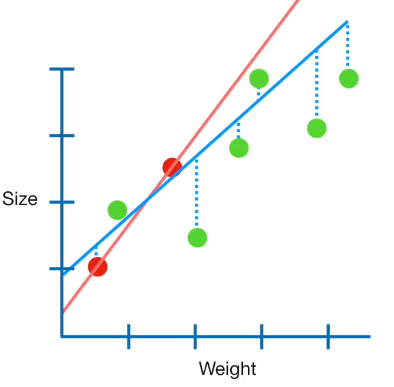
###                                            Linear Regression in Red vs Ridge Regression in Blue

In [198]:
#Calling the Ridge() function to fit and train our model
ridgeModel = Ridge()
ridgeModel.fit(featuresTrain, targetTrain)

Ridge()

In [199]:
#Making predictions using the testing set
ridgePredictions = ridgeModel.predict(featuresTest)

#Printing the mean squared error and R2 score
print("The mean squared error is: " + str(mean_squared_error(targetTest, ridgePredictions)))
print("The R2 score is: " + str(r2_score(targetTest, ridgePredictions)))

The mean squared error is: 0.003269692645359054
The R2 score is: 0.9322288178670021


In [200]:
#Creating a new dataframe for comparison purposes with original and predicted prices
comparisonDF = stockDF[['Date']][1034:]

#Adding the predictions to the dataframe
predictedRidgePrices = []
for i in ridgePredictions:
    predictedRidgePrices.append(i[0])
comparisonDF['Ridge Prediction Price'] = predictedRidgePrices

#Getting the original prices
originalPrices = []
for i in featuresTest:
    originalPrices.append(i[0])
comparisonDF['Original Prices'] = originalPrices


#Showing the new dataframe
comparisonDF

,Date,Ridge Prediction Price,Original Prices
1034,2019-05-24,0.218458,0.256484
1035,2019-05-28,0.220605,0.257890
1036,2019-05-29,0.209976,0.245143
1037,2019-05-30,0.212346,0.248747
1038,2019-05-31,0.210439,0.245934
...,...,...,...
1473,2021-02-22,0.751080,0.908835
1474,2021-02-23,0.743739,0.898418
1475,2021-02-24,0.736161,0.891165
1476,2021-02-25,0.696695,0.840527


<AxesSubplot:title={'center':'Original Prices vs Predicted Prices'}, xlabel='Date'>

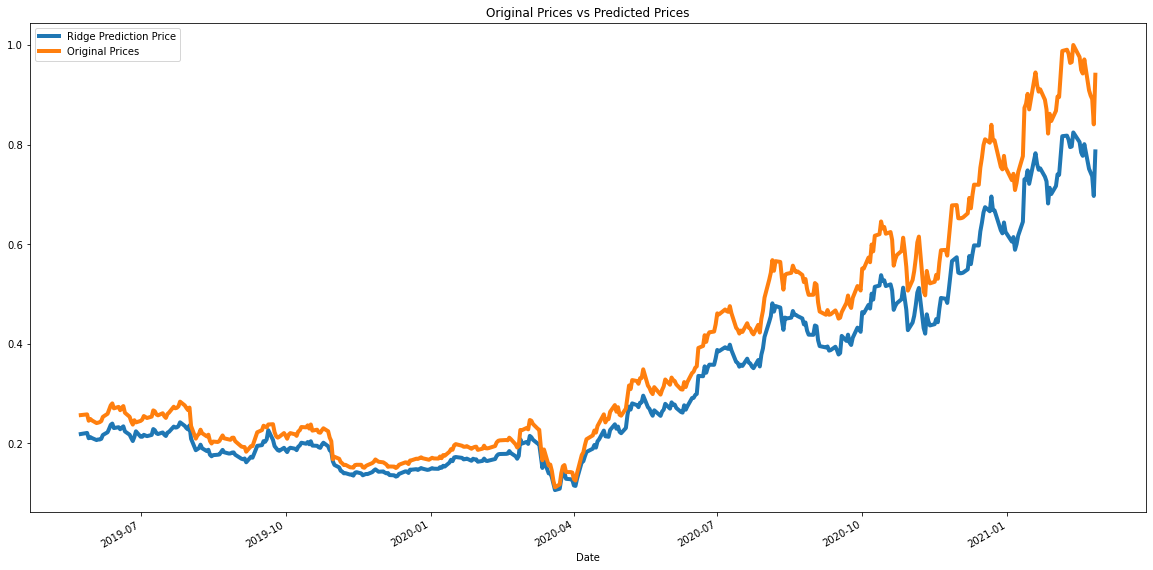

In [201]:
#Using pyplot to compare the original and predicted prices
comparisonDF.plot(x = 'Date', figsize = (20, 10), linewidth = 4, 
             title = 'Original Prices vs Predicted Prices')

#Ridge regression is very good at predicting prices for the next day but not very good at predicting prices much further out

### Step 3: LSTM Neural Network
#### How does a LSTM work?
####     - LSTM stand for "long short term memory" and is a type of recurrent neural network
####     - LSTM's work by feeding back the output of one layer at time "t" to the input of the same network layer "t + 1"
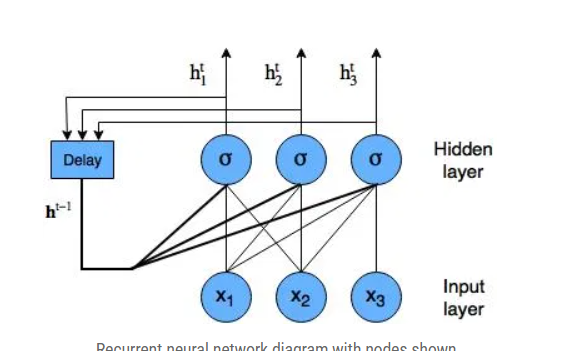
#### Why choose an LSTM?
####     - These models aren't only capable of accepting single inputs such as images or numbers but can accept entire sequences of numbers or text.
####     - LSTMs solve the "vanishing gradient" problem found in other recurrent neural networks which is when gradients can get closer and closer to 0 and no longer updates the weight.
####     - LSTMs can remember information for an arbitrary amount of time and contain gates that decide whether data can flow through them or not.
#### Excellent resource on learning more about LSTM: https://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [202]:
#Creating the training set

#Using the MinMaxScaler from sklearn to restrict the values to be from 0 to 1
scaler = MinMaxScaler(feature_range = (0, 1))
trainingData = scaler.fit_transform(stockDF.drop(columns = ['Date', 'Target'])) #Not including the date/target field
trainingData

array([[0.10391209, 0.73815549],
       [0.09327472, 0.14238304],
       [0.0814945 , 0.10884544],
       ...,
       [0.89116486, 0.0750099 ],
       [0.84052748, 0.13232138],
       [0.94026375, 0.40930741]])

In [203]:
#Setting the features and target in 60 timestps
features = []
target = []

#Looping through the length of the stock dataframe and appending the data to the lists
for i in range(60, len(stockDF)):
    features.append(trainingData[i-60:i, 0])
    target.append(trainingData[i, 0])
    
#Converting from a list to an array
features = np.asarray(features)
target = np.asarray(target)
features

array([[0.10391209, 0.09327472, 0.0814945 , ..., 0.036     , 0.04325275,
        0.0447033 ],
       [0.09327472, 0.0814945 , 0.08523077, ..., 0.04325275, 0.0447033 ,
        0.0425055 ],
       [0.0814945 , 0.08523077, 0.08246154, ..., 0.0447033 , 0.0425055 ,
        0.04461538],
       ...,
       [0.60980218, 0.67775825, 0.67841757, ..., 0.97103298, 0.90883514,
        0.89841758],
       [0.67775825, 0.67841757, 0.65191208, ..., 0.90883514, 0.89841758,
        0.89116486],
       [0.67841757, 0.65191208, 0.65169228, ..., 0.89841758, 0.89116486,
        0.84052748]])

In [204]:
#Splitting the dataset into 70% training and 30% testing
split = int(0.70 * len(features))
featuresTrain = features[:split]
featuresTest = features[split:]
targetTrain = target[:split]
targetTest = target[split:]

In [213]:
#Keras's LSTM model requires the arrays to be 3D instead of 1D
featuresTrain = np.reshape(featuresTrain, (featuresTrain.shape[0], featuresTrain.shape[1], 1))
featuresTest = np.reshape(featuresTest, (featuresTest.shape[0], featuresTest.shape[1], 1))

#Confirming they're the correct shape now
print(featuresTrain.shape)
print(featuresTest.shape)

(992, 60, 1)
(426, 60, 1)


In [214]:
#Creating the LSTM model
model = keras.models.Sequential()
model.add(keras.layers.Input(shape = (featuresTrain.shape[1], featuresTrain.shape[2])))
model.add(keras.layers.LSTM(150, return_sequences = True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(150, return_sequences = True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(150))
model.add(keras.layers.Dense(1, activation = 'linear'))

#Compiling the model
model.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 60, 150)           91200     
_________________________________________________________________
dropout_16 (Dropout)         (None, 60, 150)           0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 60, 150)           180600    
_________________________________________________________________
dropout_17 (Dropout)         (None, 60, 150)           0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 150)               180600    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 151       
Total params: 452,551
Trainable params: 452,551
Non-trainable params: 0
________________________________________________

In [215]:
#Fitting the model 
modelFit = model.fit(
    featuresTrain, 
    targetTrain,
    epochs = 20,
    batch_size = 32,
    validation_split = 0.2
)

#Experiment by increasing the epochs and changing the split

Epoch 1/20
25/25 [==============================] - 13s 514ms/step - loss: 6.2862e-04 - accuracy: 0.0013 - val_loss: 6.0055e-04 - val_accuracy: 0.0000e+00
Epoch 2/20
25/25 [==============================] - 10s 381ms/step - loss: 7.0235e-05 - accuracy: 0.0013 - val_loss: 4.1978e-04 - val_accuracy: 0.0000e+00
Epoch 3/20
25/25 [==============================] - 9s 368ms/step - loss: 6.4675e-05 - accuracy: 0.0013 - val_loss: 4.0314e-04 - val_accuracy: 0.0000e+00
Epoch 4/20
25/25 [==============================] - 9s 368ms/step - loss: 5.4276e-05 - accuracy: 0.0013 - val_loss: 5.8623e-04 - val_accuracy: 0.0000e+00
Epoch 5/20
25/25 [==============================] - 9s 359ms/step - loss: 4.9815e-05 - accuracy: 0.0013 - val_loss: 4.2262e-04 - val_accuracy: 0.0000e+00
Epoch 6/20
25/25 [==============================] - 8s 338ms/step - loss: 5.0942e-05 - accuracy: 0.0013 - val_loss: 5.0134e-04 - val_accuracy: 0.0000e+00
Epoch 7/20
25/25 [==============================] - 9s 353ms/step - loss: 

In [216]:
#Predicting future stock prices
LSTMPredictions = model.predict(featuresTest)
predictedLSTMPrices = []
for i in LSTMPredictions:
    predictedLSTMPrices.append(i[0])
    
#Examining the predictions
predictedLSTMPrices

[0.27321604,
 0.2745945,
 0.274569,
 0.27277154,
 0.26901117,
 0.26349562,
 0.25748873,
 0.25165674,
 0.24670732,
 0.24313651,
 0.24144475,
 0.24129318,
 0.24240324,
 0.2450645,
 0.24881549,
 0.25269088,
 0.25600767,
 0.2586996,
 0.260404,
 0.26091337,
 0.26082322,
 0.2606438,
 0.2612439,
 0.2625451,
 0.26432717,
 0.2664539,
 0.26919279,
 0.2719078,
 0.27392438,
 0.2747796,
 0.2747799,
 0.27212915,
 0.2654624,
 0.25589943,
 0.24521111,
 0.235405,
 0.22719483,
 0.22060916,
 0.2158895,
 0.21229868,
 0.20928204,
 0.20695324,
 0.20533729,
 0.20454386,
 0.20485543,
 0.20643379,
 0.20866786,
 0.21094854,
 0.21287839,
 0.21451299,
 0.21585675,
 0.21648751,
 0.21573378,
 0.21363747,
 0.2105965,
 0.20659128,
 0.20265713,
 0.1993738,
 0.19751094,
 0.19768009,
 0.20012893,
 0.2045404,
 0.21060367,
 0.21738724,
 0.22389749,
 0.2297781,
 0.23471884,
 0.23760687,
 0.23782015,
 0.23553088,
 0.23155916,
 0.22719656,
 0.22292954,
 0.21878947,
 0.21545401,
 0.21334633,
 0.21233678,
 0.21202609,
 0.21264

In [217]:
#Creating a dataframe for original and predicted prices
predictionDF = stockDF[['Date']][1052:]
#Adding the predicted prices to the dataframe
predictionDF['Preidcted LSTM Prices'] = predictedLSTMPrices
predictionDF

#Getting the original prices
split = int(0.70 * len(features))
featuresTest = features[split:]
originalStockPrices = []
for i in featuresTest:
    originalStockPrices.append(i[0])
    
#Adding the original prices to the dataframe
predictionDF['Original Prices'] = originalStockPrices
predictionDF

,Date,Preidcted LSTM Prices,Original Prices
1052,2019-06-20,0.273216,0.269802
1053,2019-06-21,0.274594,0.260000
1054,2019-06-24,0.274569,0.267121
1055,2019-06-25,0.272772,0.267516
1056,2019-06-26,0.269011,0.271648
...,...,...,...
1473,2021-02-22,0.930303,0.588308
1474,2021-02-23,0.923475,0.576879
1475,2021-02-24,0.912632,0.609802
1476,2021-02-25,0.898927,0.677758


<AxesSubplot:title={'center':'Original Prices vs Predicted Prices'}, xlabel='Date'>

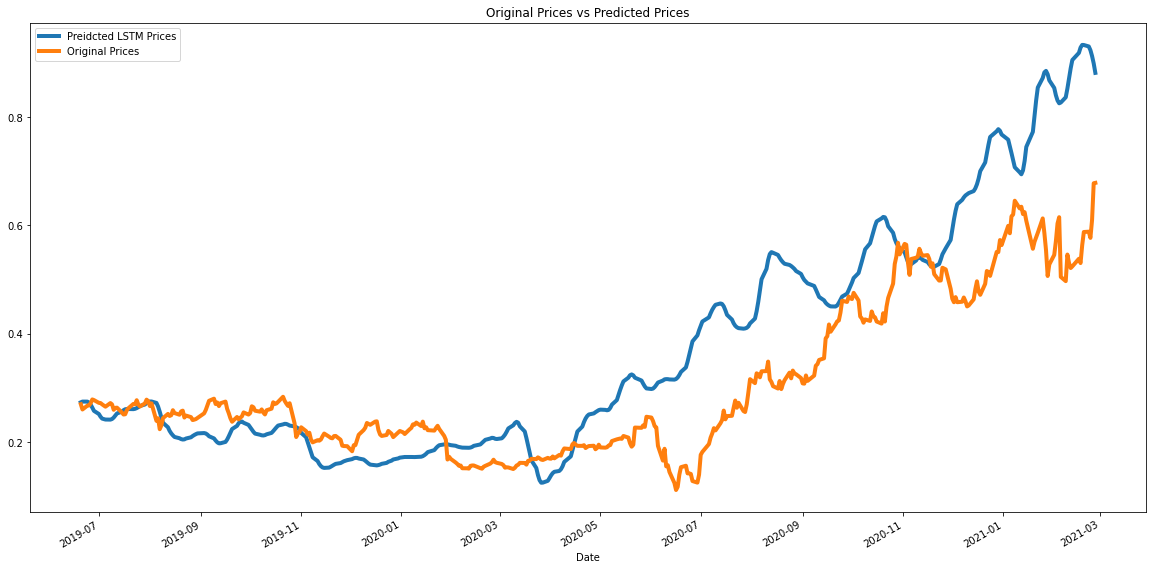

In [218]:
#Using pyplot to compare the original and predicted prices
predictionDF.plot(x = 'Date', figsize = (20, 10), linewidth = 4, 
             title = 'Original Prices vs Predicted Prices')